# Mount Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Set environment

In [1]:
%cd {'drive/MyDrive/DJIA'}

/content/drive/MyDrive/DJIA


# Load Libraries

In [2]:
%load_ext autoreload
%autoreload 2

# load and manipulate
import numpy as np
import pandas as pd 

# load pretrained ensemble models
import joblib

# load pretrained keras models
from tensorflow import keras

# plotting libraries
import seaborn as sns
import matplotlib.pyplot as plt

# ensemble classifier
from xgboost import XGBClassifier

# metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

Import scikit plot to plot roc-auc curves

In [3]:
!pip install -q scikit-plot
import scikitplot as skplt

# Load Data

In [3]:
!pip install --upgrade -q tables
data = pd.read_hdf('data/ts_cl.h5', 'all_features')

In [4]:
# avoid sklearn future warning
data.columns = data.columns.astype(str)
data.drop('fwd_returns', axis=1, inplace=True)

In [5]:
cv_data = data.loc[:'2016-03']

In [6]:
def get_train_test(cv_data):
    train_data_len = int(len(cv_data)*0.8)
    X = cv_data.drop(['Label'], axis=1)
    y = cv_data.Label

    X_train = X.iloc[:train_data_len]
    y_train = y.iloc[:train_data_len]

    X_test = X.iloc[train_data_len:]
    y_test = y.iloc[train_data_len:]
    return (X_train, X_test, y_train, y_test)

## Get train-test split

In [7]:
X_train, X_test, y_train, y_test = get_train_test(cv_data)

In [8]:
window=60
sequence = list(range(1, window+1))
sequence = [str(x) for x in sequence]

In [9]:
X_train_lstm = [
             X_train.loc[:, sequence].values.reshape(-1, window, 1),  # get first window returns
             X_train.filter(like='topic'),  # get main news topics
             X_train.filter(like='ind')     # indicators from ts
]
y_train_lstm = y_train

In [10]:
X_test_lstm = [
             X_test.loc[:, sequence].values.reshape(-1, window, 1),  # get first window returns
             X_test.filter(like='topic'),  # get main news topics
             X_test.filter(like='ind')     # indicators from ts
]
y_test_lstm = y_test

## Get Out-of-bag Data

In [11]:
oob_data = data.loc['2016-04':]  # leave june as out of sample testing

Ensemble X, y out of bag data

In [12]:
X_oob_ens = oob_data.drop('Label', axis=1)
y_oob_ens = oob_data.Label

Keras Tuned LSTM out of bag data

In [13]:
X_oob_lstm = [
           oob_data.loc[:, sequence].values.reshape(-1, window, 1),  # get first window returns
           oob_data.filter(like='topic'),  # get main news topics
           oob_data.filter(like='ind')     # indicators from ts
]
y_oob_lstm = oob_data.Label

# Load Pretrained Models

## Load Ensembles

In [14]:
soft_ensemble = joblib.load('results/classic_models/SOFT_VOTING.joblib')
hard_ensemble = joblib.load('results/classic_models/HARD_VOTING.joblib')

## Load Two Layer LSTM Tuned

In [15]:
lstm_2l_5576 = keras.models.load_model('results/bayes_2lstm/bayes_5576_train.h5')
lstm_2l_5858 = keras.models.load_model('results/bayes_2lstm/bayes_5868_train.h5')
lstm_2l_5278 = keras.models.load_model('results/bayes_2lstm/sliding_bayes_2l_train.h5')

## Load Three Layer LSTM Tuned

In [16]:
lstm_3l_5438 = keras.models.load_model('results/bayes_3lstm/sliding_bayes_3l_train.h5')

# Compare Models

In [17]:
lstm_models = [
               {
                   'label' : 'lstm_2l_5576',
                   'model' : lstm_2l_5576,
               },
               {
                   'label' : 'lstm_2l_5858',
                   'model' : lstm_2l_5858,
               },
               {
                   'label' : 'lstm_2l_5278',
                   'model' : lstm_2l_5278,
               },
               {
                   'label' : 'lstm_3l_5438',
                   'model' : lstm_3l_5438,
               },

]

ensemble_models = [
                   {
                       'label' : 'soft_ensemble',
                       'model' : soft_ensemble,
                   },
                   {
                       'label' : 'hard_ensemble',
                       'model' : hard_ensemble,
                   },
]

## Test-Set

### Classification Reports

In [ ]:
def get_classification_reports(models, X_test, y_test):
    for m in models:
        model = m['model']
        y_pred = (model.predict(X_test) >= 0.5).astype(int)
        print("="*30, m['label'], "="*30)
        print(classification_report(y_test, y_pred))

In [ ]:
# lstm models
get_classification_reports(lstm_models, X_test_lstm, y_test_lstm)
# ensembles
get_classification_reports(ensemble_models, X_test, y_test)

============================== lstm_2l_5576 ==============================
              precision    recall  f1-score   support

           0       0.50      0.61      0.55       184
           1       0.52      0.40      0.45       189

    accuracy                           0.51       373
   macro avg       0.51      0.51      0.50       373
weighted avg       0.51      0.51      0.50       373

============================== lstm_2l_5858 ==============================
              precision    recall  f1-score   support

           0       0.51      0.43      0.47       184
           1       0.52      0.59      0.55       189

    accuracy                           0.51       373
   macro avg       0.51      0.51      0.51       373
weighted avg       0.51      0.51      0.51       373

============================== lstm_2l_5278 ==============================
              precision    recall  f1-score   support

           0       0.54      0.27      0.36       184
           1

The best accuracy is obtained by lstm_3l_5438, with an accuracy of 56. In addition, is the one with the most balanced f1-score. That is, it doesn't tend to predict one class more than the other. That might be very helpful for periods where the market is in a channel, since it will have no preference between labels and will make better decisions. In contrast, we have lstm_2l_5276, and the ensembles, which seem to lean towards the label 1 in a significant manner. Being the f1-score almost twice as big for the hard ensemble and the lstm_2l_5276. The rest of two layer lstm models, perform decent, despite having one one f1-score below 0.5 each. 

### ROC Curve (Receiver Operating Characteristics)

In [ ]:
def get_roc_auc_plots(models, X_test, y_test):
    for m in models:
        model = m['model']
        y_pred = model.predict(X_test)
        fpr, tpr, thresholds = roc_curve(y_test, y_pred)
        # Calculate Area under the curve to display on the plot
        auc = roc_auc_score(y_test, y_pred)
        # Now, plot the computed values
        plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (m['label'], auc))

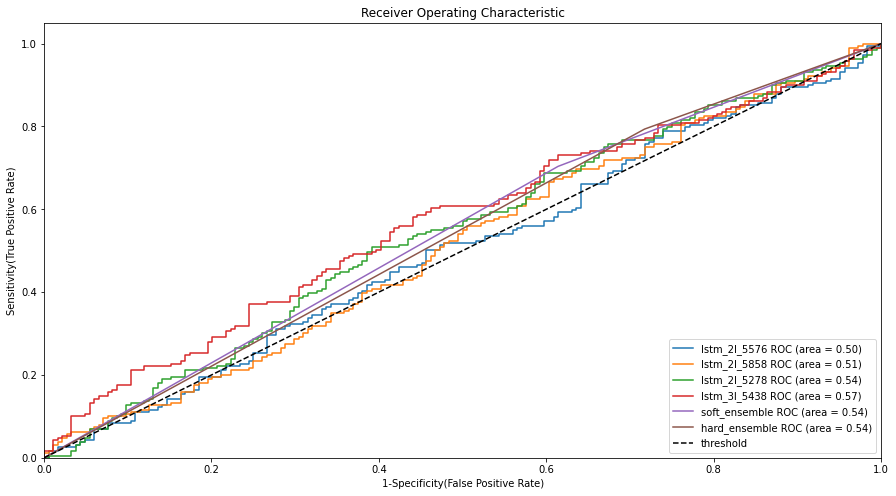

In [ ]:
plt.figure(figsize=(15, 8))
# lstm models roc auc plots
get_roc_auc_plots(lstm_models, X_test_lstm, y_test_lstm)
# ensembles
get_roc_auc_plots(ensemble_models, X_test, y_test)
rand_pred = len(y_test[y_test==1])/len(y_test)

plt.plot([0, 1], [0, 1],'r--', label='threshold', color='black')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity(False Positive Rate)')
plt.ylabel('Sensitivity(True Positive Rate)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()   # Display


The three layers stacked LSTM seems to have the best ROC, with a value of 0.57, which is relatively far from the rest. The soft and hard ensembles perform equal and get the same score as the two layer stacked lstm 5278. The worse performing models on the test set are the 2 layer lstm 5576 and the two layer lstm 5858. Nonetheless, none of them gets below 0.5, hence, not worse than random, hopefully.

### Precision-Recall Curves (PR Curves)

In [ ]:
def get_precision_recall_plots(models, X_test, y_test, soft=False):
    for m in models:
        model = m['model']
        if soft:
            y_pred = model.predict_proba(X_test)[:,1]
        else:
            y_pred = model.predict(X_test)
        fpr, tpr, thresholds = roc_curve(y_test, y_pred)
        # Calculate Area under the curve to display on the plot
        precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
        # Now, plot the computed values
        plt.plot(recall, precision, label='%s Precision-Recall Curve (area = %0.2f)' % (m['label'], auc(fpr, tpr)))

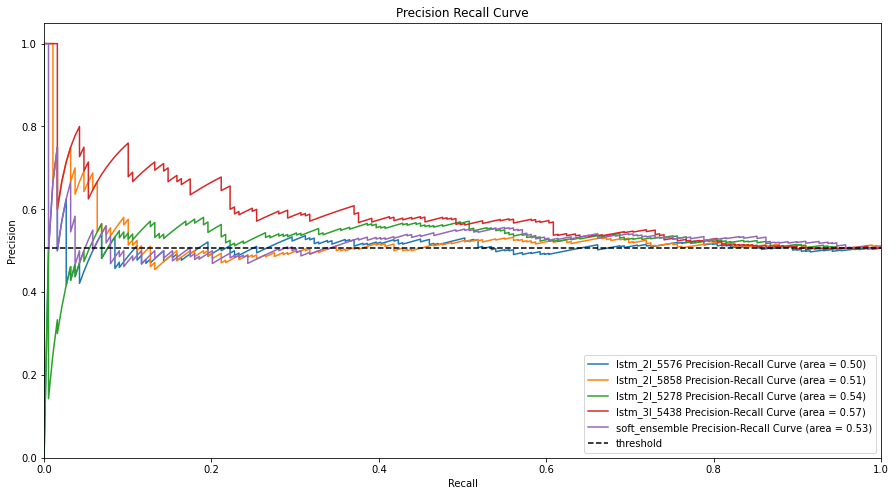

In [ ]:
plt.figure(figsize=(15, 8))
# lstm models roc auc plots
get_precision_recall_plots(lstm_models, X_test_lstm, y_test_lstm)
# ensembles
get_precision_recall_plots([ensemble_models[0]], X_test, y_test, soft=True)
rand_pred = len(y_test[y_test==1])/len(y_test)
plt.plot([0, 1],[rand_pred, rand_pred],'r--', label='threshold', color='black')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision Recall Curve')
plt.legend(loc="lower right")
plt.show()   # Display

On average, models do better than just predicting always buy, which looks like a good indication. Specially lstm_3l_5438, which just gets way above the threshold and, in fact, never gets below it. Being the only model that never performs worse than the threshold. In this case, the hard voting ensemble was excluded, since it is incapable to give probabilities. In general, as the recall approaches 1.0, precision coincides with the threshold.

### Confusion Matrices

In [ ]:
def plot_conf_matrices(models, X_test, y_test, nn=False):
    for m in models:
        model = m['model']
        if nn:
            y_pred = (model.predict(X_test) >= 0.5).astype(int)
        else:
            y_pred = model.predict(X_test)
        plt.figure(figsize=(6,6))
        plt.title(label=f"{m['label']} Confusion Matrix")
        conf_mat = confusion_matrix(y_test, y_pred)
        sns.heatmap(conf_mat/np.sum(conf_mat), 
                    square=True, annot=True, 
                    cmap='Blues', fmt='.2%', 
                    cbar=False)

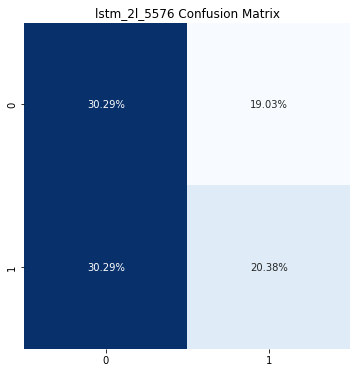

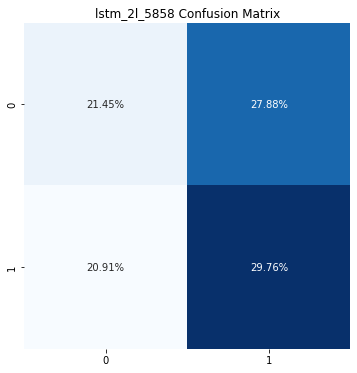

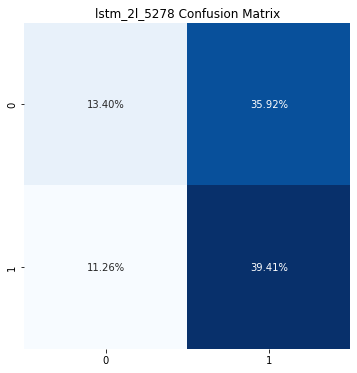

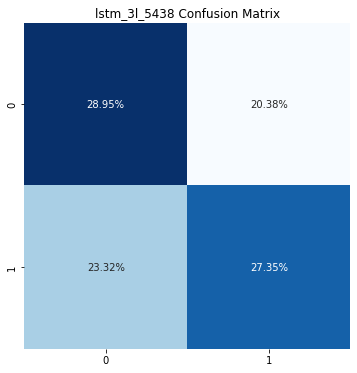

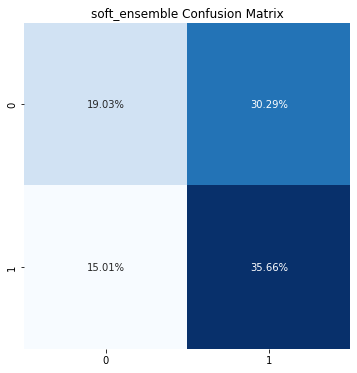

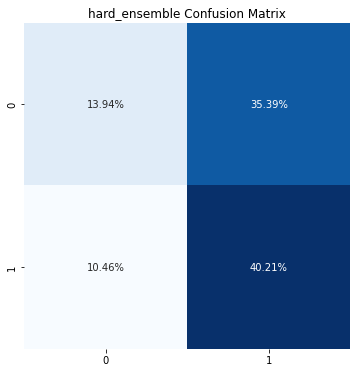

In [ ]:
plot_conf_matrices(lstm_models, X_test_lstm, y_test_lstm, nn=True)
plot_conf_matrices(ensemble_models, X_test, y_test)


1.   Seems to have a clear tendency towards predicting 0
2.   Clear tendency towards predicting 1
3.   The biggest polarity in the prediction of labels. Between three and four times the weight of 1s vs 0s correctly classified.
4.   The model with clearer intent in predicing. Has some false negatives, tries to predict 0 when it is 1, but in general, the percentage of true negative and true positive is the highest.
5.   Finally, both ensembles show a clear tendency towards voting 1. Specially the hard ensemble, which creates a rate of false positives greater than the amount of 0s predicted.



Before moving into out of bag performance, let's look what we can get in the test set by stacking the top 2 performing models: 

**lstm_3l_5438, lstm_2l_5278**

### Build Stacking Ensemble Class

In [23]:
from src.Stacking import StackedEnsemble

### Train Stacking Ensemble

In [24]:
# add the top two performing models (AUC):
stack_models = [lstm_3l_5438, lstm_2l_5278]
Ensemble = StackedEnsemble(stack_models, X_train_lstm, y_train_lstm)

### Save Trained Stacking Ensemble model

In [ ]:
joblib.dump(Ensemble, 'djia_models/StackingEnsemble.joblib')

### Add Stacking Ensemble to LSTM models

In [21]:
lstm_models.append({
    'label' : 'Stacking Ensemble',
    'model' : Ensemble
})

## Analyze Stacking Ensemble Metrics:

### Classification Report

In [25]:
y_pred = Ensemble.predict(X_test_lstm)
print("="*30, "Stacking Ensemble", "="*30)
print(classification_report(y_test_lstm, y_pred))

============================== Stacking Ensemble ==============================
              precision    recall  f1-score   support

           0       0.53      0.38      0.44       184
           1       0.53      0.67      0.59       189

    accuracy                           0.53       373
   macro avg       0.53      0.52      0.51       373
weighted avg       0.53      0.53      0.52       373



Accuracy score doesn't get much better, in fact, is a little worse than the best performing model. However, we expect to have less variance in the results. Hopefully, that will mean our model behaves about the same with the out of bag samples. The rest of the models, might change their behaviour.

### ROC curve

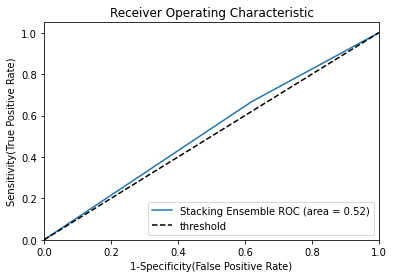

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test_lstm, y_pred)
# Calculate Area under the curve to display on the plot
auc_ = roc_auc_score(y_test_lstm, y_pred)
# Now, plot the computed values
plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % ("Stacking Ensemble", auc_))
plt.plot([0, 1], [0, 1],'r--', label='threshold', color='black')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity(False Positive Rate)')
plt.ylabel('Sensitivity(True Positive Rate)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()   # Display

ROC curve is above the threshold at all times and presents pretty good stability.

### Precision Recall Curve

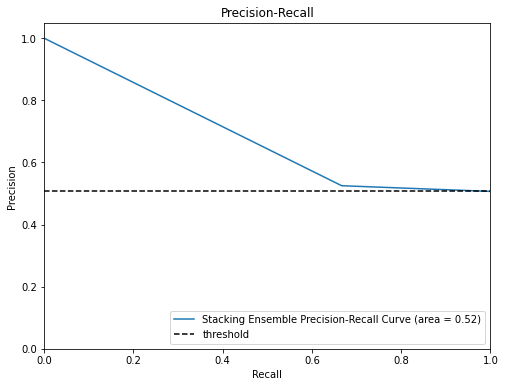

In [ ]:
plt.figure(figsize=(8, 6))
fpr, tpr, thresholds = roc_curve(y_test_lstm, y_pred)
# Calculate Area under the curve to display on the plot
precision, recall, thresholds = precision_recall_curve(y_test_lstm, y_pred)
# Now, plot the computed values
plt.plot(recall, precision, label='Stacking Ensemble Precision-Recall Curve (area = %0.2f)' %auc(fpr, tpr))
rand_pred = len(y_test[y_test==1])/len(y_test)
plt.plot([0, 1],[rand_pred, rand_pred],'r--', label='threshold', color='black')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall')
plt.legend(loc="lower right")
plt.show()   # Display

Great stability, and always above the threshold.

### Confusion Matrix

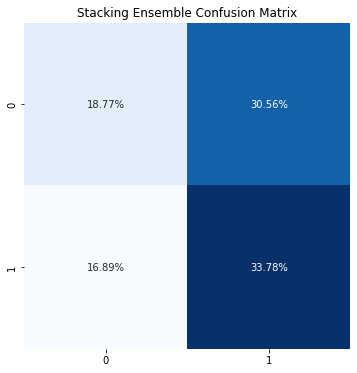

In [ ]:
plt.figure(figsize=(6,6))
plt.title(label="Stacking Ensemble Confusion Matrix")
conf_mat = confusion_matrix(y_test_lstm, y_pred)
sns.heatmap(conf_mat/np.sum(conf_mat), 
        square=True, annot=True, 
        cmap='Blues', fmt='.2%', 
        cbar=False);

Despite having a bunch of false positives, it actually does a decent job at detecting true negatives.

Now that we have examined the output of the test set, let's look at what happens with out of bag performance, where any other pattern than the one learned or tested before can happen.

Due to the success of the stacking ensemble, we will test it in our out of bag samples

## Out of Bag

### Classification Reports

In [ ]:
# lstm models
get_classification_reports(lstm_models, X_oob_lstm, y_oob_lstm)
# ensembles
get_classification_reports(ensemble_models, X_oob_ens, y_oob_ens)

# y_pred = Ensemble.predict(X_oob_lstm)
# print("="*30, "Stacking Ensemble", "="*30)
# print(classification_report(y_oob_lstm, y_pred))

============================== lstm_2l_5576 ==============================
              precision    recall  f1-score   support

           0       0.53      0.71      0.61        28
           1       0.70      0.51      0.59        37

    accuracy                           0.60        65
   macro avg       0.62      0.61      0.60        65
weighted avg       0.63      0.60      0.60        65

============================== lstm_2l_5858 ==============================
              precision    recall  f1-score   support

           0       0.47      0.54      0.50        28
           1       0.61      0.54      0.57        37

    accuracy                           0.54        65
   macro avg       0.54      0.54      0.54        65
weighted avg       0.55      0.54      0.54        65

============================== lstm_2l_5278 ==============================
              precision    recall  f1-score   support

           0       0.56      0.32      0.41        28
           1



1.   First model performs best, having the best f1-score ratio. And achieving an accuracy of 60%.
2.   Gets to 54% accuracy and equal or above 50 f1-scores. 
3.   Gets a great f1 score with 1s, but gets pretty bad f1-score predicting 0s. Achieves a 60% accuracy, however.
4.   Despite being the top performer in the test-set, now has an accuracy below 50% (below threshold)
5.   Stacking ensemble gets the best f1-score of 1s and the 0s f1-score is above 50. Not only it has avoided the catastrophic predictions of the three layer model, but it has also improved by a 5% the accuracy achieved by the top performing simple model.
6.   Both classic model ensembles perform poorly, not getting to 50% accuracy and low f1-scores.



### ROC Curve (Receiver Operating Characteristics)

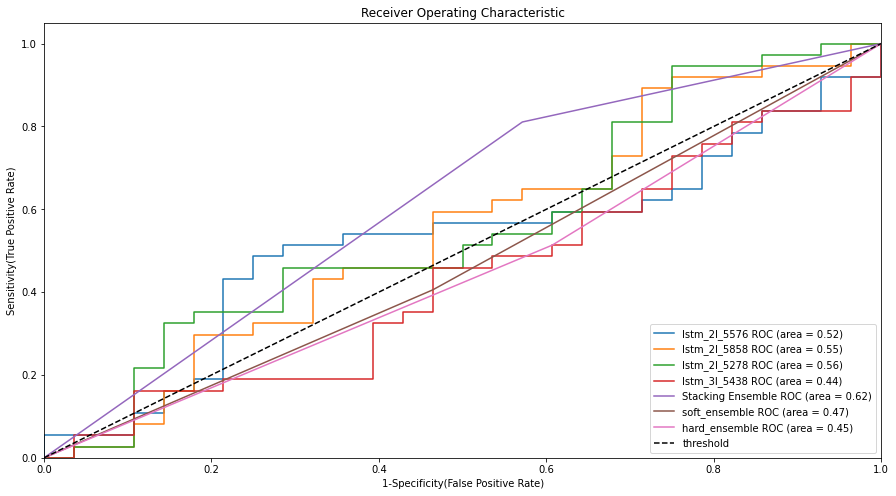

In [ ]:
plt.figure(figsize=(15, 8))
# lstm models roc auc plots
get_roc_auc_plots(lstm_models, X_oob_lstm, y_oob_lstm)
# ensembles
get_roc_auc_plots(ensemble_models, X_oob_ens, y_oob_ens)

plt.plot([0, 1], [0, 1],'r--', label='threshold', color='black')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity(False Positive Rate)')
plt.ylabel('Sensitivity(True Positive Rate)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()   # Display

Stacking ensemble gets the best AUC by far, getting to up to **62**. The hard and soft ensembles perform really poorly, below 50 AUC. 2 layer lstms do better than the three layer lstm. The three layer lstm, used to be the top performer, now is the worse performing algorithm. However, its stacking ensemble with **lstm_2l_5278**, performs best by far. 

### Precision-Recall Curves (PR Curves)

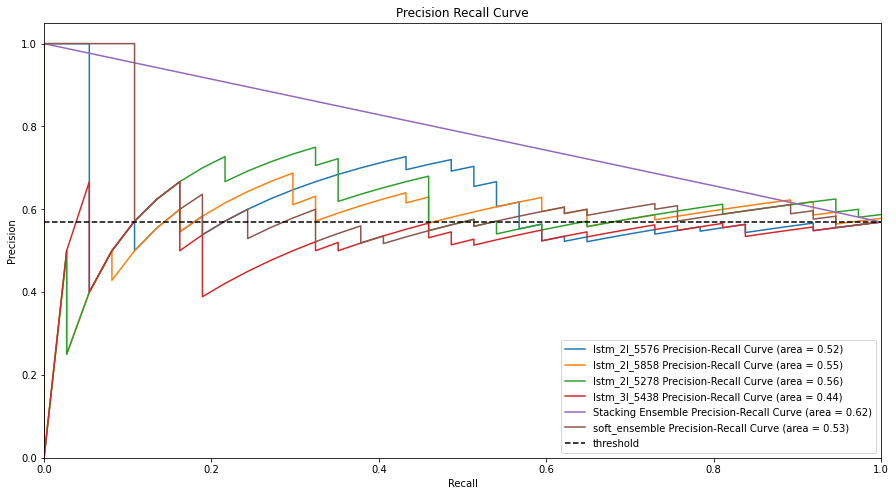

In [ ]:
plt.figure(figsize=(15, 8))
# lstm models roc auc plots
get_precision_recall_plots(lstm_models, X_oob_lstm, y_oob_lstm)
# ensembles
get_precision_recall_plots([ensemble_models[0]], X_oob_ens, y_oob_ens, soft=True)
rand_pred = len(y_oob_ens[y_oob_ens==1])/len(y_oob_ens)

plt.plot([0, 1],[rand_pred, rand_pred],'r--', label='threshold', color='black')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision Recall Curve')
plt.legend(loc="lower right")
plt.show()   # Display

We see that threshold is much higher than 0.5 now. The threshold is in fact almost at 0.6. The only model tthat is consistenly above, is the stacking ensemble.

### Confusion Matrices

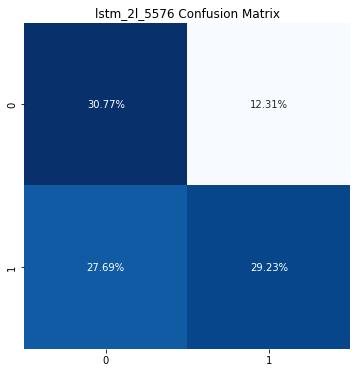

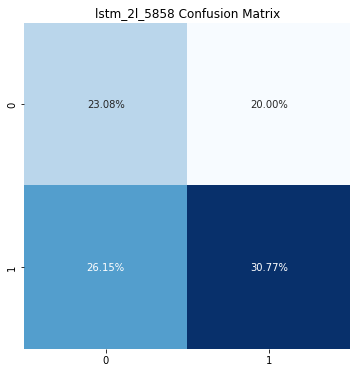

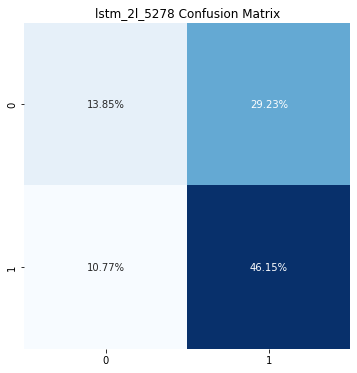

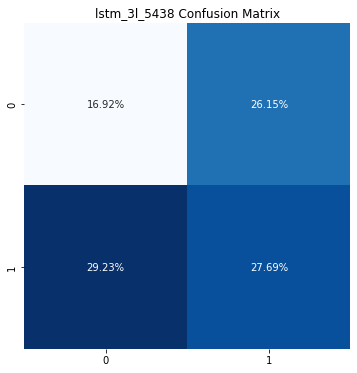

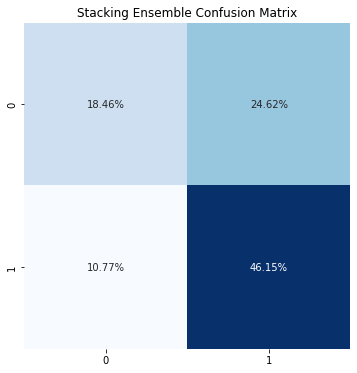

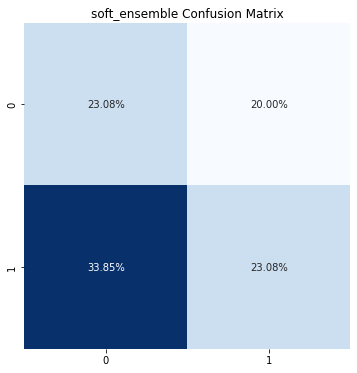

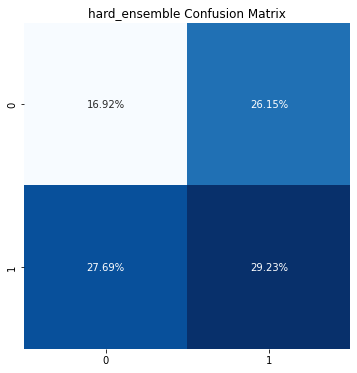

In [ ]:
# lstm models
plot_conf_matrices(lstm_models, X_oob_lstm, y_oob_lstm, nn=True)
# Ensembles
plot_conf_matrices(ensemble_models, X_oob_ens, y_oob_ens)



1.   High false negative rate, however, higher true positive and true negative rates.
2.   High rate of true positives, higher rate of false negatives than true negatives. 
3.   High rate of false positives, really high rate of true positives and relatively low true negative rate. Model has a strong tendency towards predicting 1.
4.  Really high rate of false negatives, and high rate of true positives and false positives. 
5.  From the previous two models, learns true positives and also stops predicting so many positives and increases the true negative rate.
6.  Lots of false negatives, same rate of true positives and true negatives.
7.  Great true positive rate, however, almost equal false positive and false negative rates.



# Conclusion

The most estable model seems to be the stacked ensemble model of top 2 test models. It achieves the best f1-scores and is in both cases above the threshold at all times. It could be further improved by adding a neural net instead of XGBoost to join probabilities of the models.